# Convergent Cross Mapping
This notebook and package is reproducing the results from [
Detecting Causality in Complex Ecosystems](http://science.sciencemag.org/content/338/6106/496)

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors
import seaborn as sns
sns.set_style('ticks')
sns.set_context(context='paper',font_scale=1.5)
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import skCCM as ccm
import skCCM.data as data

In [ ]:
ccm.utilities.

## Work Flow
A coupled logistic map. Here is what we are going to do:

1. Generate the time series
2. Calculate the mutual information of the time series
3. Embed the time series (not going to explore embedding dimension, just lag)
4. Analyze forecast skill for a range of library lengths

### 1. Generate the time series

In [4]:
rx1 = 3.72 #determines chaotic behavior of the x1 series
rx2 = 3.72 #determines chaotic behavior of the x2 series
b12 = 0.2 #Influence of x1 on x2
b21 = 0.01 #Influence of x2 on x1
ts_length = 1000
x1,x2 = data.coupled_logistic(rx1,rx2,b12,b21,ts_length)

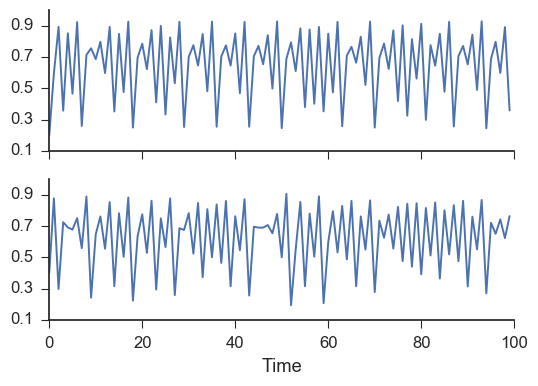

In [5]:
fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True)
ax[0].plot(x1[0:100])
ax[1].plot(x2[0:100])
ax[0].set_yticks([.1,.3,.5,.7,.9])
ax[1].set_xlabel('Time')
sns.despine()

In [6]:
#fig.savefig('../figures/coupled_logistic.png',bbox_inches='tight')

### 2. Calculate the mutual information

In [7]:
e1 = ccm.Embed(x1)
e2 = ccm.Embed(x2)

In [8]:
mi1 = e1.mutual_information(10)
mi2 = e2.mutual_information(10)

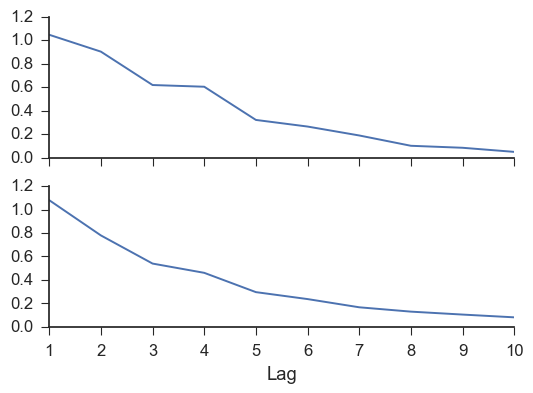

In [9]:
fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True)
ax[0].plot(np.arange(1,11),mi1)
ax[1].plot(np.arange(1,11),mi2)
ax[1].set_xlabel('Lag')
sns.despine()

In [10]:
#fig.savefig('../figures/mutual_info.png',bbox_inches='tight')

### 3. Embed the time series

In [11]:
lag = 1
embed = 2
X1 = e1.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)

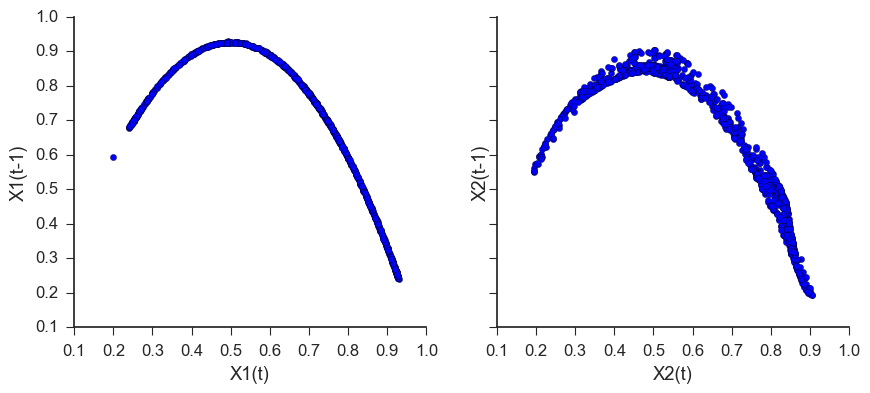

In [12]:
fig,ax = plt.subplots(ncols=2,sharey=True,sharex=True,figsize=(10,4)) 
ax[0].scatter(X1[:,0],X1[:,1])
ax[1].scatter(X2[:,0],X2[:,1])
ax[0].set_xlabel('X1(t)')
ax[0].set_ylabel('X1(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')
sns.despine()

In [13]:
#fig.savefig('../figures/x_embedded.png',bbox_inches='tight')

### 4. Forecast skill as a function of library length
Same legend as above.

In [ ]:
ccm.utilities.

In [17]:
CCM = ccm.paper.CCM()

AttributeError: module 'skCCM' has no attribute 'paper'

### Split it into a testing set and training set

In [55]:
len_X1 = len(X1)
lib_lens = np.arange(10, len_X1, len_X1/20, dtype='int')

In [56]:
lib_lens

array([ 10,  59, 108, 157, 206, 255, 304, 353, 402, 451, 500, 549, 598,
       647, 696, 745, 794, 843, 892, 941])

In [57]:
X2

array([[ 0.4       ,  0.89099776,  0.29486125],
       [ 0.89099776,  0.29486125,  0.75177031],
       [ 0.29486125,  0.75177031,  0.69279636],
       ..., 
       [ 0.43840264,  0.89421458,  0.33348046],
       [ 0.89421458,  0.33348046,  0.82215795],
       [ 0.33348046,  0.82215795,  0.51157837]])

In [58]:
CCM.fit(X1,X2)
x1p, x2p = CCM.predict_drop_in_list(lib_lens)
sc1,sc2 = CCM.score()

ValueError: total size of new array must be unchanged

In [59]:
nrows = 10
ncols = 5
ar = np.arange(0,ncols)

ind = [np.random.permutation(ar) for i in range(nrows)]

#X = np.random.randint(0,4,size=(4,10))
ind = np.vstack(ind)
dist = np.random.rand(nrows,ncols)
ind

array([[2, 0, 1, 3, 4],
       [2, 1, 3, 4, 0],
       [2, 1, 0, 3, 4],
       [0, 1, 4, 3, 2],
       [1, 3, 4, 0, 2],
       [0, 1, 4, 3, 2],
       [2, 1, 3, 0, 4],
       [4, 0, 1, 3, 2],
       [2, 3, 4, 0, 1],
       [1, 4, 0, 3, 2]])

In [60]:
g = np.arange(nrows*2).reshape(nrows,2)
g

array([[ 0,  1],
       [ 2,  3],
       [ 4,  5],
       [ 6,  7],
       [ 8,  9],
       [10, 11],
       [12, 13],
       [14, 15],
       [16, 17],
       [18, 19]])

In [64]:
ccm.utilities.throw_out_nn_indices(dist,ind,g)

ValueError: total size of new array must be unchanged

In [65]:
%debug

> /Users/nickc/Documents/skCCM/skCCM/utilities.py(153)throw_out_nn_indices()
    151         mask_store = np.vstack(mask_store)
    152 
--> 153         ind = ind[mask_store].reshape(ind.shape[0],ind.shape[1]-Xind.shape[1])
    154         dist = dist[mask_store].reshape(dist.shape[0],dist.shape[1]-Xind.shape[1])
    155 

ipdb> ind
array([[2, 0, 1, 3, 4],
       [2, 1, 3, 4, 0],
       [2, 1, 0, 3, 4],
       [0, 1, 4, 3, 2],
       [1, 3, 4, 0, 2],
       [0, 1, 4, 3, 2],
       [2, 1, 3, 0, 4],
       [4, 0, 1, 3, 2],
       [2, 3, 4, 0, 1],
       [1, 4, 0, 3, 2]])
ipdb> mask_store
array([[ True, False, False,  True,  True],
       [False,  True, False,  True,  True],
       [ True,  True,  True,  True, False],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ Tr

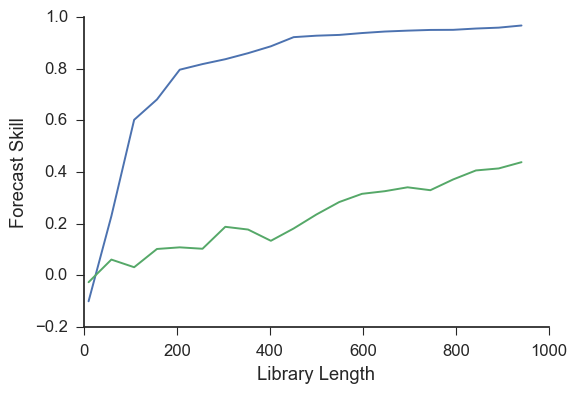

In [35]:
fig,ax = plt.subplots()
ax.plot(lib_lens,sc1,label='X1 xmap X2')
ax.plot(lib_lens,sc2, label='X2 xmap X1')
ax.set_xlabel('Library Length')
ax.set_ylabel('Forecast Skill')
sns.despine()

In [19]:
#fig.savefig('../figures/xmap_lib_len.png',bbox_inches='tight')

### For a single library length

## Reproducing the plot from the paper
The paper explores different values for b12 and b21 in Figure 3B.

In [36]:
X1.shape

(999, 2)

In [38]:
rx1 = 3.7 #determines chaotic behavior of the x1 series
rx2 = 3.7 #determines chaotic behavior of the x2 series

ts_length = 1000

#variables for embedding
lag = 1
embed = 2

CCM = ccm.paper.CCM() #intitiate the ccm object

#store values
num_b = 20 #number of bs to test
sc1_store = np.empty((num_b,num_b))
sc2_store = np.empty((num_b,num_b))

#values over which to test
max_b = .4 #maximum b values
b_range = np.linspace(0,max_b,num=num_b)

In [43]:
#loop through b values for b12 and b21
for ii,b12 in enumerate(b_range):
    for jj, b21 in enumerate(b_range):
        
        x1,x2 = data.coupled_logistic(rx1,rx2,b12,b21,ts_length)
        
        em_x1 = ccm.Embed(x1)
        em_x2 = ccm.Embed(x2)
        
        X1 = em_x1.embed_vectors_1d(lag,embed)
        X2 = em_x2.embed_vectors_1d(lag,embed)
        
        
        CCM.fit(X1,X2)
        x1p, x2p = CCM.predict_no_drop([len(X1)])
        sc1,sc2 = CCM.score()
        
        sc1_store[ii,jj] = sc1[0] #only the one prediction out
        sc2_store[ii,jj] = sc2[0]
        
sc_diff = sc2_store-sc1_store

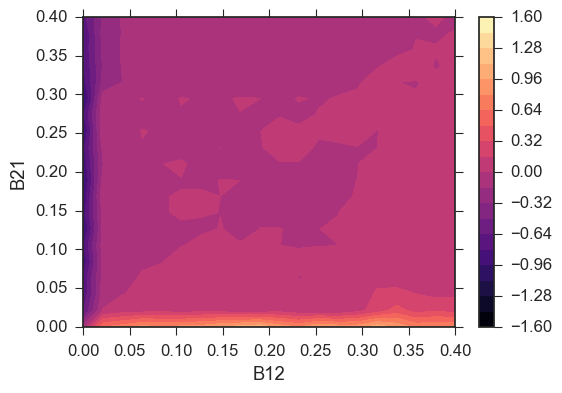

In [44]:
fig,ax = plt.subplots()
v = np.linspace(-1.6,1.6,21)
cax = ax.contourf(b_range,b_range,sc_diff,v,cmap='magma')
fig.colorbar(cax,ticks=v[::2])
ax.set_xlabel('B12')
ax.set_ylabel('B21')

In [26]:
#fig.savefig('../figures/xmap_changingB.png',bbox_inches='tight')

## Randomly forced

In [45]:
rx2 = 3.72 #determines chaotic behavior of the x2 series
b12 = .2 #Influence of x1 on x2

ts_length = 1000
x1,x2 = data.driven_rand_logistic(rx2,b12,ts_length)

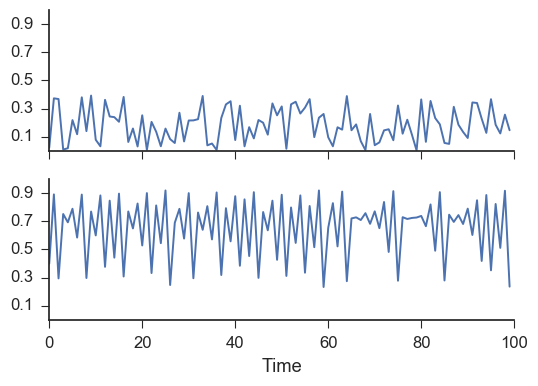

In [46]:
fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True)
ax[0].plot(x1[0:100])
ax[1].plot(x2[0:100])
ax[0].set_yticks([.1,.3,.5,.7,.9])
ax[1].set_xlabel('Time')
sns.despine()

In [48]:
e1 = ccm.Embed(x1)
e2 = ccm.Embed(x2)

In [49]:
mi1 = e1.mutual_information(10)
mi2 = e2.mutual_information(10)

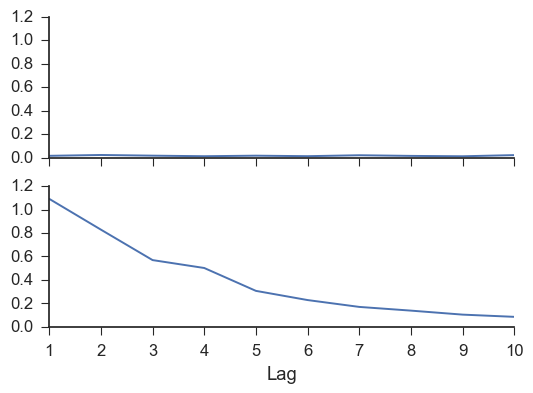

In [50]:
fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True)
ax[0].plot(np.arange(1,11),mi1)
ax[1].plot(np.arange(1,11),mi2)
ax[1].set_xlabel('Lag')
sns.despine()

In [51]:
lag = 1
embed = 3

X1 = e1.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)

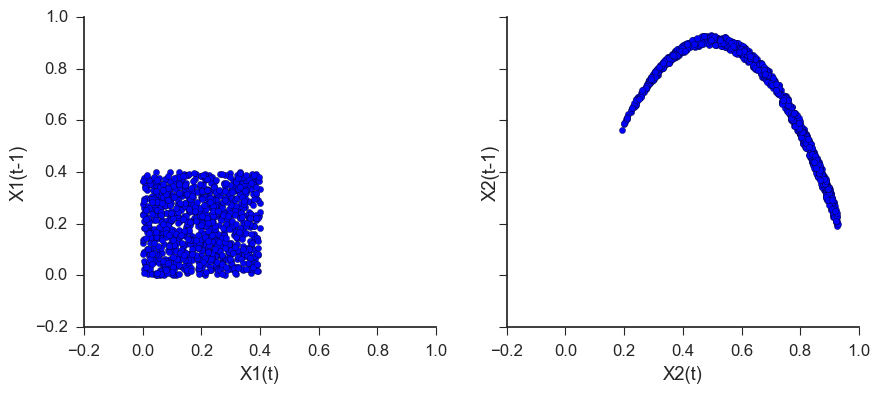

In [52]:
fig,ax = plt.subplots(ncols=2,sharey=True,sharex=True,figsize=(10,4)) 
ax[0].scatter(X1[:,0],X1[:,1])
ax[1].scatter(X2[:,0],X2[:,1])
ax[0].set_xlabel('X1(t)')
ax[0].set_ylabel('X1(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')
sns.despine()

In [53]:
CCM = ccm.paper.CCM()

In [35]:
X1.shape

(998, 3)

In [36]:
lib_lens = np.arange(10,ts_length,ts_length/20,dtype='int')

x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

sc1, sc2 = CCM.predict_causation(x1tr, x1te, x2tr, x2te,lib_lens)

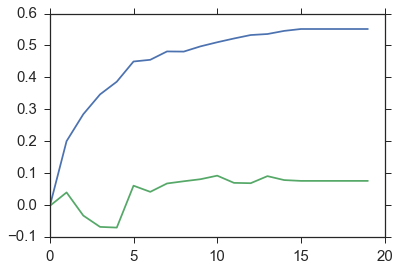

In [37]:
plt.plot(sc1)
plt.plot(sc2)

## Periodic Forcing

In [38]:
rx2 = 3.72 #determines chaotic behavior of the x2 series
b12 = .5 #Influence of x1 on x2

ts_length = 1000
x1,x2 = data.driving_sin(rx2,b12,ts_length)

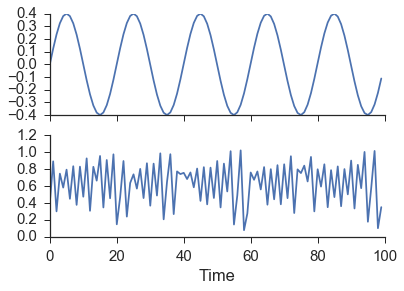

In [39]:
fig,ax = plt.subplots(nrows=2,sharex=True)
ax[0].plot(x1[0:100])
ax[1].plot(x2[0:100])
ax[1].set_xlabel('Time')
sns.despine()

In [40]:
em_x1 = ccm.embed(x1)
em_x2 = ccm.embed(x2)

In [41]:
mi1 = em_x1.mutual_information(10)
mi2 = em_x2.mutual_information(10)

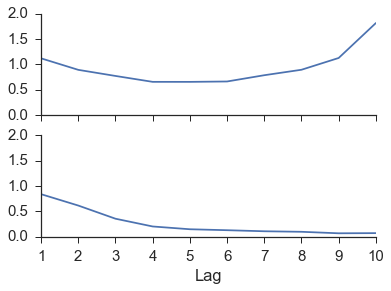

In [42]:
fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True)
ax[0].plot(np.arange(1,11),mi1)
ax[1].plot(np.arange(1,11),mi2)
ax[1].set_xlabel('Lag')
sns.despine()

In [43]:
lag1 = 4
lag2 = 1
embed = 3

X1 = em_x1.embed_vectors_1d(lag1,embed)
X2 = em_x2.embed_vectors_1d(lag2,embed)

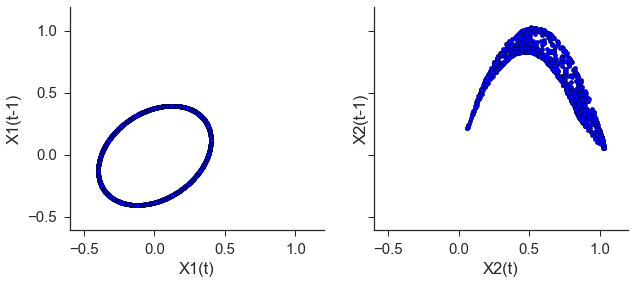

In [44]:
fig,ax = plt.subplots(ncols=2,sharey=True,sharex=True,figsize=(10,4)) 
ax[0].scatter(X1[:,0],X1[:,1])
ax[1].scatter(X2[:,0],X2[:,1])
ax[0].set_xlabel('X1(t)')
ax[0].set_ylabel('X1(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')
sns.despine()

In [45]:
CCM = ccm.ccm()

In [46]:
X2.shape

(998, 3)

In [47]:
print("X1 xmap X2:", sc1)
print("X2 xmap X1:", sc2)

X1 xmap X2: [-0.00392169  0.19994526  0.28450109  0.34659078  0.38644699  0.44977397
  0.45510745  0.48132646  0.48083796  0.49723929  0.5101393   0.52192703
  0.53279656  0.53595407  0.54576827  0.55169028  0.55169028  0.55169028
  0.55169028  0.55169028]
X2 xmap X1: [-0.00302837  0.03913796 -0.03349662 -0.06894004 -0.07110764  0.06029848
  0.04098114  0.06725904  0.07417394  0.08062177  0.09174646  0.06914174
  0.0681219   0.09026979  0.07789655  0.07534586  0.07534586  0.07534586
  0.07534586  0.07534586]


In [48]:
lib_lens = np.arange(10,ts_length,ts_length/20,dtype='int')
sc1, sc2 = CCM.predict_causation(X1[:500],X1[500:900],X2[:500],X2[500:900],lib_lens)

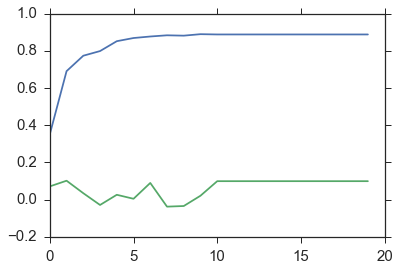

In [49]:
plt.plot(sc1)
plt.plot(sc2)

## Lagged Coupled Logistic

In [50]:
rx1 = 3.72 #determines chaotic behavior of the x1 series
rx2 = 3.72 #determines chaotic behavior of the x2 series
b12 = 0.01 #Influence of x1 on x2
b21 = 0.3 #Influence of x2 on x1
ts_length = 8000
x1,x2 = data.lagged_coupled_logistic(rx1,rx2,b12,b21,ts_length)

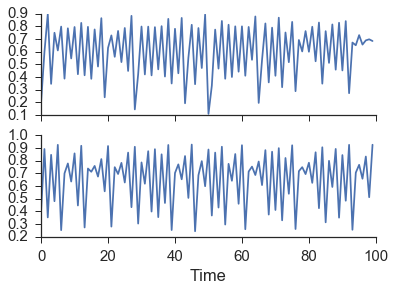

In [51]:
fig,ax = plt.subplots(nrows=2,sharex=True)
ax[0].plot(x1[0:100])
ax[1].plot(x2[0:100])
ax[1].set_xlabel('Time')
sns.despine()

In [52]:
em_x1 = ccm.embed(x1)
em_x2 = ccm.embed(x2)

In [53]:
mi1 = em_x1.mutual_information(10)
mi2 = em_x2.mutual_information(10)

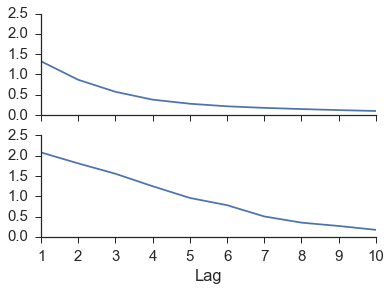

In [54]:
fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True)
ax[0].plot(np.arange(1,11),mi1)
ax[1].plot(np.arange(1,11),mi2)
ax[1].set_xlabel('Lag')
sns.despine()

In [55]:
lag1 = 4
lag2 = 1
embed = 3

X1 = em_x1.embed_vectors_1d(lag1,embed)
X2 = em_x2.embed_vectors_1d(lag2,embed)

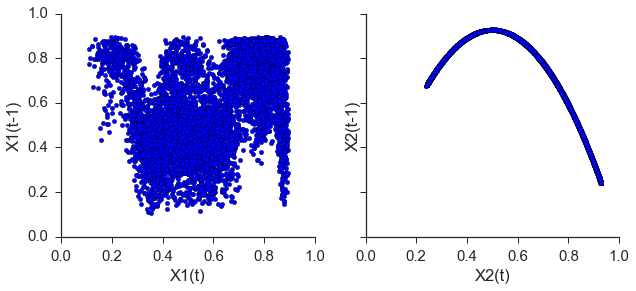

In [56]:
fig,ax = plt.subplots(ncols=2,sharey=True,sharex=True,figsize=(10,4)) 
ax[0].scatter(X1[:,0],X1[:,1])
ax[1].scatter(X2[:,0],X2[:,1])
ax[0].set_xlabel('X1(t)')
ax[0].set_ylabel('X1(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')
sns.despine()

In [57]:
CCM = ccm.ccm(score_metric='corrcoef')

In [58]:
lib_lens = np.arange(10,ts_length/2,ts_length/20,dtype='int')
sc1, sc2 = CCM.predict_causation(X1[:5000],X1[5000:7500],X2[:5000],X2[5000:7500],lib_lens)

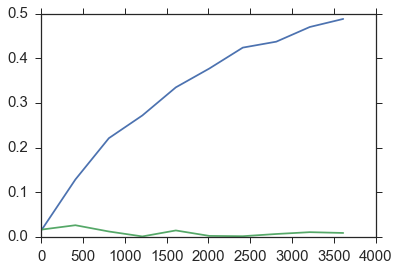

In [59]:
plt.plot(lib_lens,sc1)
plt.plot(lib_lens,sc2)

## Random Linearly Increasing

In [60]:
ts_length=1000
x1 = np.random.randn(ts_length,) + np.linspace(0,25,ts_length)
x2 = np.random.randn(ts_length,) + np.linspace(0,10,ts_length)

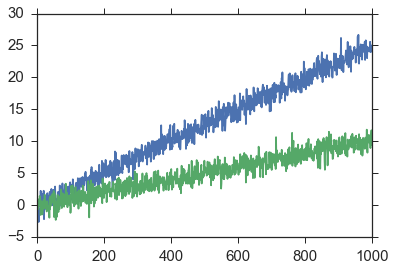

In [61]:
plt.plot(x1)
plt.plot(x2)

In [62]:
em_x1 = ccm.embed(x1)
em_x2 = ccm.embed(x2)

In [63]:
mi1 = em_x1.mutual_information(20)
mi2 = em_x2.mutual_information(20)

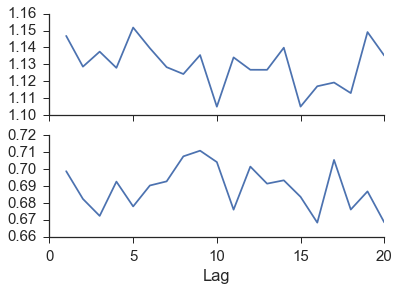

In [64]:
fig,ax = plt.subplots(nrows=2,sharex=True)
ax[0].plot(np.arange(1,21),mi1)
ax[1].plot(np.arange(1,21),mi2)
ax[1].set_xlabel('Lag')
sns.despine()

In [65]:
lag1 = 2
lag2 = 2
embed = 8

X1 = em_x1.embed_vectors_1d(lag1,embed)
X2 = em_x2.embed_vectors_1d(lag2,embed)

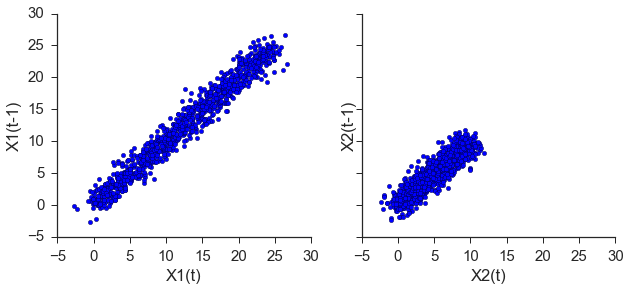

In [66]:
fig,ax = plt.subplots(ncols=2,sharey=True,sharex=True,figsize=(10,4)) 
ax[0].scatter(X1[:,0],X1[:,1])
ax[1].scatter(X2[:,0],X2[:,1])
ax[0].set_xlabel('X1(t)')
ax[0].set_ylabel('X1(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')
sns.despine()

In [67]:
CCM = ccm.ccm(score_metric='corrcoef')

In [68]:
X1.shape

(986, 8)

In [69]:
lib_lens = np.arange(10,len(X1)/2,len(X1)/2/20,dtype='int')
sc1, sc2 = CCM.predict_causation(X1[:700],X1[700:],X2[:700],X2[700:],lib_lens)

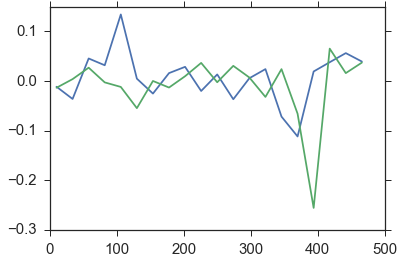

In [70]:
plt.plot(lib_lens,sc1)
plt.plot(lib_lens,sc2)

### Cosine and Sine Waves

In [71]:
ts_length=50
x1 = np.random.randn(ts_length,) + 10*np.sin(np.linspace(0,10*np.pi,ts_length))
x2 = np.random.randn(ts_length,) + 20*np.cos(np.linspace(0,10*np.pi,ts_length))

#x1[x1<0] = np.random.randn(np.sum(x1<0),)
#x2[x2<0] = np.random.randn(np.sum(x2<0),)

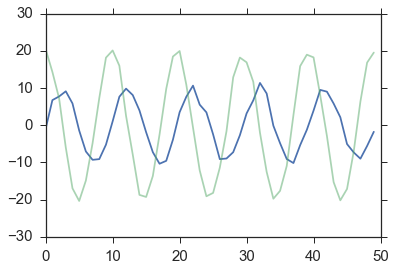

In [72]:
plt.plot(x1)
plt.plot(x2,alpha=.5)

In [73]:
em_x1 = ccm.embed(x1)
em_x2 = ccm.embed(x2)
mi1 = em_x1.mutual_information(10)
mi2 = em_x2.mutual_information(10)

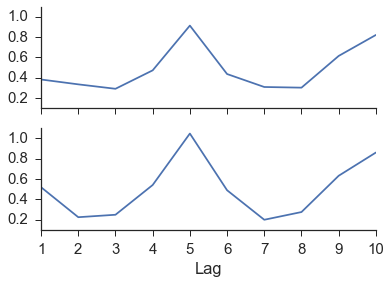

In [74]:
fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True)
ax[0].plot(np.arange(1,11),mi1)
ax[1].plot(np.arange(1,11),mi2)
ax[1].set_xlabel('Lag')
sns.despine()

In [75]:
lag1 = 2
lag2 = 2
embed = 4

X1 = em_x1.embed_vectors_1d(lag1,embed)
X2 = em_x2.embed_vectors_1d(lag2,embed)

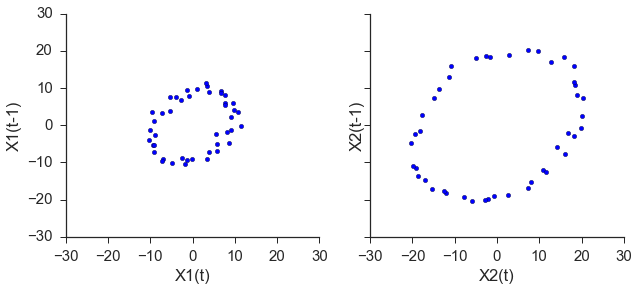

In [76]:
fig,ax = plt.subplots(ncols=2,sharey=True,sharex=True,figsize=(10,4)) 
ax[0].scatter(X1[:,0],X1[:,1])
ax[1].scatter(X2[:,0],X2[:,1])
ax[0].set_xlabel('X1(t)')
ax[0].set_ylabel('X1(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')
sns.despine()

In [77]:
X1.shape

(44, 4)

In [78]:
CCM = ccm.ccm(score_metric='corrcoef')

In [79]:
x1_len = len(X1)

In [80]:
x1tr, x1te, x2tr, x2te = ccm.utilities.train_test_split(X1,X2)

In [81]:
lib_lens

array([ 10,  34,  58,  82, 106, 130, 154, 178, 202, 226, 250, 274, 298,
       322, 346, 370, 394, 418, 442, 466])

In [82]:
lib_lens = np.arange(5,len(x1tr)/2,len(x1tr)/20,dtype='int')
sc1, sc2 = CCM.predict_causation(x1tr, x1te, x2tr, x2te,lib_lens)

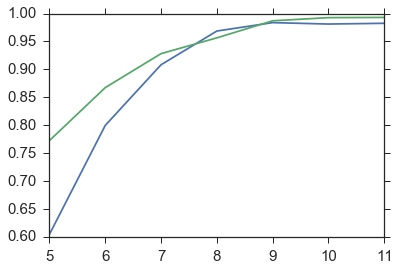

In [83]:
plt.plot(lib_lens,sc1)
plt.plot(lib_lens,sc2)

### Brown Noise

seed = 11, produces small variance in x2 and large variance in x1

In [84]:
def brown_noise_gen(ts_length,seed):
    x1 = np.zeros(ts_length)
    x2 = np.zeros(ts_length)
    np.random.seed(seed)
    x1[0] = np.random.randn()
    x2[0] = np.random.randn()
    for ii in range(ts_length-1):
        x1[ii+1]  = np.random.randn() + x1[ii] 
        x2[ii+1] = np.random.randn() + x2[ii]
    
    return x1,x2
    

In [85]:
#fig,axes = plt.subplots(10,10,figsize=(20,20))
#ax = axes.ravel()
ts_length=2000
iterations = 1000
S = np.zeros(iterations)
lib_lens = np.arange(50,ts_length/2,ts_length/2/20,dtype='int')
sc1 = np.zeros((iterations,len(lib_lens)))
sc2 = np.zeros((iterations,len(lib_lens)))
x1_store = np.zeros((iterations,2000))
x2_store = np.zeros((iterations,2000))
for ii in range(iterations):
    
    
    #np.random.seed(np.random.randint(0,10000,dtype='int'))
    #r_seed = np.random.randint(0,10000,dtype='int')
    x1,x2 = brown_noise_gen(2000,ii)

    x1_store[ii,:] = x1
    x2_store[ii,:] = x2
    
    em_x1 = ccm.embed(x1)
    em_x2 = ccm.embed(x2)
    lag1 = 20
    lag2 = 20
    embed = 3

    X1 = em_x1.embed_vectors_1d(lag1,embed)
    X2 = em_x2.embed_vectors_1d(lag2,embed)
    
    
    x1tr, x1te, x2tr, x2te = ccm.utilities.train_test_split(X1,X2,percent=.5)
    CCM = ccm.ccm(score_metric='corrcoef')
    
    sc1[ii,:], sc2[ii,:] = CCM.predict_causation(x1tr, x1te, x2tr, x2te,lib_lens)
    S[ii] = np.sum(sc1[ii,:]-sc2[ii,:])
    

In [86]:
X1.shape

(1960, 3)

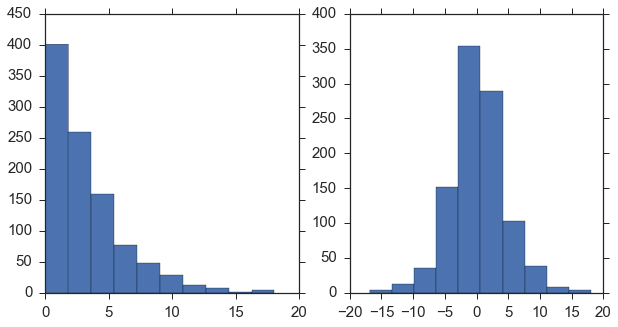

In [87]:
fig,ax = plt.subplots(ncols=2,figsize=(10,5))
ax[0].hist(np.abs(S))
ax[1].hist(S);

In [88]:
#fig.savefig('../figures/ccm_hist.png',bbox_inches='tight')

In [89]:
top_vals = np.argsort(np.abs(S))[::-1]
print(top_vals[0:10])

[ 26 369 306 424 311 697 714 149 687 575]


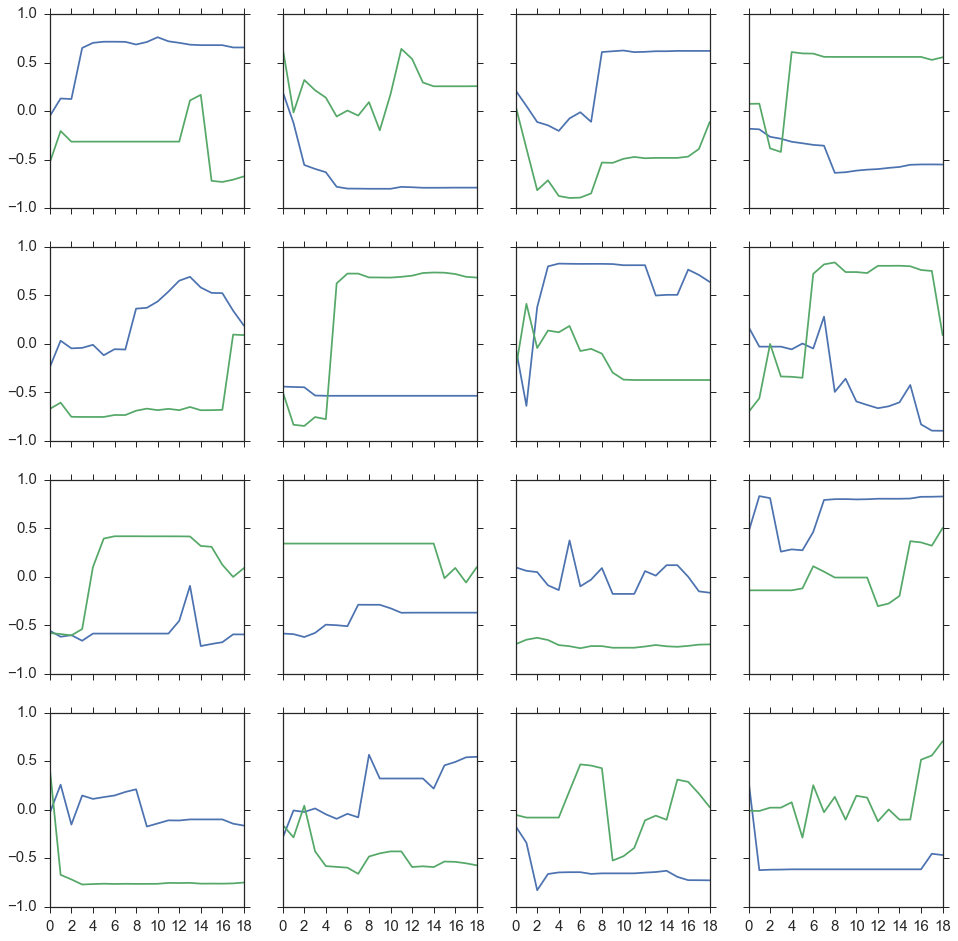

In [90]:
fig,axes = plt.subplots(4,4,figsize=(16,16),sharex=True,sharey=True)
ax = axes.ravel()

for ii in range(16):
    ax[ii].plot(sc1[top_vals[ii],:])
    ax[ii].plot(sc2[top_vals[ii],:])
    ax[ii].set_ylim(-1,1)

In [91]:
#fig.savefig('../figures/top_ccm.png',bbox_inches='tight')

### plot the top eight and their corresponding ts

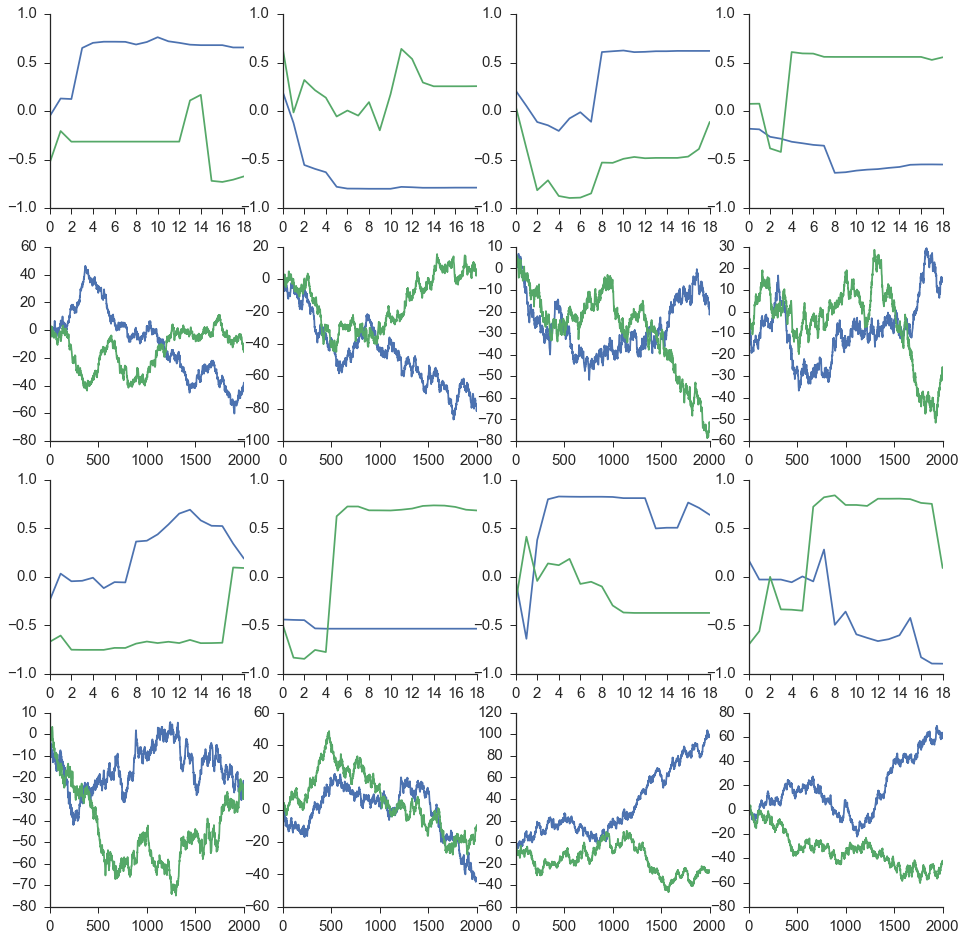

In [92]:
fig,axes = plt.subplots(4,4,figsize=(16,16))
ax = axes.ravel()
ts_list = [0,1,2,3,8,9,10,11]
c_list = [4,5,6,7,12,13,14,15]
for ii in range(8):
    ax[ts_list[ii]].plot(sc1[top_vals[ii],:])
    ax[ts_list[ii]].plot(sc2[top_vals[ii],:])
    ax[ts_list[ii]].set_ylim(-1.,1.)
    
    ax[c_list[ii]].plot(x1_store[top_vals[ii],:])
    ax[c_list[ii]].plot(x2_store[top_vals[ii],:])
sns.despine()

In [93]:
#fig.savefig('../figures/top_ccm_with_series.png',bbox_inches='tight')